In [1]:
import requests
import io
import os
import warnings
import re
import nltk
import gensim
import numpy as np
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt

nltk.download('punkt')
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize
from gensim.models import Word2Vec

import keras
import tensorflow
from keras.preprocessing.text import one_hot,Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence
from sklearn.model_selection import train_test_split

from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout

tensorflow.random.set_seed(7)
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'nltk'

In [2]:
URL = "https://raw.githubusercontent.com/TalLinzen/rnn_agreement/master/data/wiki.vocab"
download = requests.get(URL).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')),sep = '\t')

In [3]:
!wget http://tallinzen.net/media/rnn_agreement/rnn_agr_simple.tar.gz
!tar -xzvf "rnn_agr_simple.tar.gz" -C .

--2023-08-07 17:50:21--  http://tallinzen.net/media/rnn_agreement/rnn_agr_simple.tar.gz
Resolving tallinzen.net (tallinzen.net)... 185.199.108.153
Connecting to tallinzen.net (tallinzen.net)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tallinzen.net/media/rnn_agreement/rnn_agr_simple.tar.gz [following]
--2023-08-07 17:50:21--  https://tallinzen.net/media/rnn_agreement/rnn_agr_simple.tar.gz
Connecting to tallinzen.net (tallinzen.net)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41326466 (39M) [application/gzip]
Saving to: ‘rnn_agr_simple.tar.gz’

rnn_agr_simple.tar. 100%[===================>]  39.41M  --.-KB/s    in 0.1s    

2023-08-07 17:50:24 (293 MB/s) - ‘rnn_agr_simple.tar.gz’ saved [41326466/41326466]

./._rnn_agr_simple
rnn_agr_simple/
rnn_agr_simple/._.README.txt.un~
rnn_agr_simple/.README.txt.un~
rnn_agr_simple/._numpred.test
rnn_agr_simple/numpred.test
rnn_agr_simp

In [4]:
df_train = pd.read_csv('rnn_agr_simple/numpred.train',sep = '\t', names = ['POS', "Preamble"])
df_val = pd.read_csv('rnn_agr_simple/numpred.val',sep = '\t', names = ['POS', "Preamble"])

In [5]:
df_train

,POS,Preamble
0,VBZ,the second
1,VBZ,the JJ general
2,VBP,these projects
3,VBP,i think that 's what the NN is requesting for ...
4,VBZ,the greek word translated as mark ( of the bea...
...,...,...
141943,VBP,the ticket cards
141944,VBZ,"NNP 's NNP NN , a popular measure of income NN..."
141945,VBZ,a further advanced pregnancy was reported in s...
141946,VBZ,as timber


In [6]:
df_train["Preamble"] = df_train["Preamble"].apply(lambda s: ' '.join(re.sub("[.(),``!?:;-='...@_]", " ", s).split()))

In [7]:
df_train.POS.unique()  # VBZ is singular and VBP is plural

array(['VBZ', 'VBP'], dtype=object)

In [8]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

sentences=[]
sum = 0
for pre in df_train['Preamble']:
    sents=tokenizer.tokenize(pre.strip())
    sum+=len(sents)
    for sent in sents:
        sentences.append(sent.split())

In [9]:
model= gensim.models.Word2Vec(sentences=sentences,vector_size=250,window=10,min_count=1)
model.train(sentences,epochs=10,total_examples=len(sentences))
vocab = model.wv #unique words i.e vocab in the dataset
len(vocab)

9930

In [10]:
words = list(model.wv.index_to_key) #list of words
word2vec_dict={}
for word in words:
    word2vec_dict[word]= model.wv.get_vector(word)

In [11]:
max=-1
for i,pre in enumerate(df_train['Preamble']):
    tokens=pre.split()
    if(len(tokens)>max):
        max=len(tokens)

print(max)

47


In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['Preamble'])
vocab_size = len(tokenizer.word_index) + 1
encoded_vec = tokenizer.texts_to_sequences(df_train['Preamble'])

In [13]:
max_len= 47
vocab_size = len(tokenizer.word_index) + 1
embedding_dim= 250

In [14]:
pad= pad_sequences(encoded_vec, maxlen=max_len, padding='post')

In [15]:
#embedding matrix
embed_matrix=np.zeros(shape=(vocab_size,embedding_dim))
for word,i in tokenizer.word_index.items():
    vector=word2vec_dict.get(word)
    if vector is not None:
        embed_matrix[i] = vector

In [16]:
df_train.loc[df_train["POS"] == "VBZ", "POS"] = 0
df_train.loc[df_train["POS"] == "VBP", "POS"] = 1

In [17]:
Y=keras.utils.to_categorical(df_train['POS'])
x_train,x_test,y_train,y_test = train_test_split(pad,Y,test_size=0.20,random_state=42)

In [18]:
#Simple LSTM Model

model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim = embedding_dim,input_length= max_len,embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(128,return_sequences=False))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(2,activation='sigmoid'))

In [19]:
model.compile(optimizer = keras.optimizers.RMSprop(lr=1e-3),loss='binary_crossentropy',metrics=['accuracy'])
History = model.fit(x_train,y_train,epochs = 20,batch_size = 64,validation_data=(x_test,y_test))

Epoch 1/20
1775/1775 [==============================] - 21s 9ms/step - loss: 0.1556 - accuracy: 0.9463 - val_loss: 0.0714 - val_accuracy: 0.9713
Epoch 2/20
1775/1775 [==============================] - 15s 9ms/step - loss: 0.0520 - accuracy: 0.9845 - val_loss: 0.0410 - val_accuracy: 0.9868
Epoch 3/20
1775/1775 [==============================] - 15s 8ms/step - loss: 0.0320 - accuracy: 0.9911 - val_loss: 0.0396 - val_accuracy: 0.9876
Epoch 4/20
1775/1775 [==============================] - 16s 9ms/step - loss: 0.0212 - accuracy: 0.9941 - val_loss: 0.0557 - val_accuracy: 0.9894
Epoch 5/20
1775/1775 [==============================] - 15s 8ms/step - loss: 0.0151 - accuracy: 0.9962 - val_loss: 0.0382 - val_accuracy: 0.9892
Epoch 6/20
1775/1775 [==============================] - 16s 9ms/step - loss: 0.0115 - accuracy: 0.9973 - val_loss: 0.0708 - val_accuracy: 0.9890
Epoch 7/20
1775/1775 [==============================] - 16s 9ms/step - loss: 0.0084 - accuracy: 0.9982 - val_loss: 0.0649 - val_ac

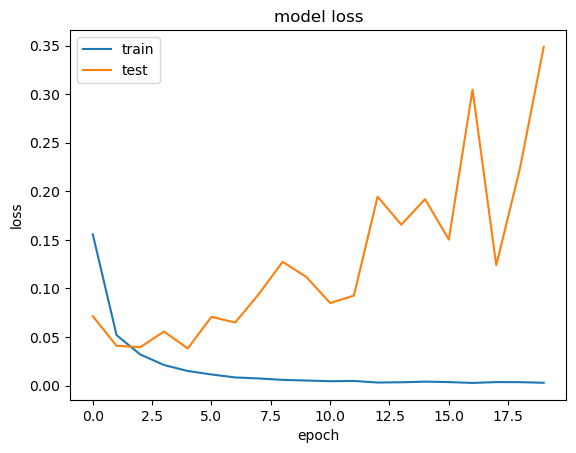

In [20]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

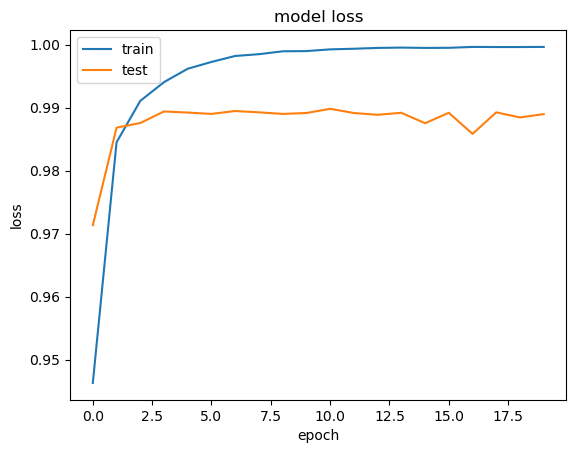

In [21]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
#BERT Classification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer
from tensorflow.keras.optimizers import Adam, SGD

In [72]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [75]:
#Binary Classification using BERT

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train['Preamble'],df_train['POS'], stratify=df_train['POS'])

In [77]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [78]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [4]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

NameError: name 'tf' is not defined

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [ ]:
X_train = tf.convert_to_tensor(X_train, np.float32)
y_train = tf.convert_to_tensor(y_train, np.float32)

In [ ]:
model.fit(X_train, y_train, epochs=10)